<a href="https://colab.research.google.com/github/anwishn/ESAA/blob/main/1114_%EA%B3%BC%EC%A0%9C_santander_creditcard_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

파이썬 머신러닝 완벽가이드 p.252-277

## 08. 분류 실습 - 캐글 산탄데르 고객 만족 예측



---

캐글의 산탄데르 고객 만족 데이터 세트에 대해서 고객 만족 여부를 XGBoost와 LightGBM 활용해 예측

* 370개의 피처(모두 익명 처리)
* 클래스 레이블 명은 TARGET. 이 값이 1이면 불만 가진 고객, 0이면 만족한 고객
* 모델의 성능 평가는 ROC-AUC(ROC 곡선 영역) (<-대부분이 만족이므로 정확도 수치보다 더 적합)

### 데이터 전처리

* 필요한 모듈 로딩. 학습 데이터를 DataFrame으로 로딩

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

cust_df = pd.read_csv("/content/drive/MyDrive/data/santander-customer-satisfaction/train_santander.csv", encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


=> 클래스 값 칼럼을 포함한 피처가 371개 존재

* 피처의 타입과 Null 값 알아보기

In [52]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


=> 111개의 피처가 float형, 260개의 피처가 int형으로 모든 피처가 숫자 형. Null값은 없다

* 전체 데이터에서 만족과 불만족의 비율 살펴보기 -> 레이블인 Target 속성의 값의 분포

In [53]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET']==1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt/total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


=> 대부분이 만족이며 불만족인 고객은 얼마 되지 않는 4%

* 각 피처의 값 분포 간단히 확인

In [54]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


=> var3 칼럼의 경우 min값이 -999999(NaN이나 특정 예외 값을 -99999로 변환했을 것)

* -999999를 가장 값이 많은 2로 변환. ID 피처는 단순 식별자이므로 피처 드롭. 클래스 데이터 세트와 피처 데이터 세트를 분리해 별도의 데이터 세트로 별도 저장

In [55]:
cust_df['var3'].replace(-999999,2,inplace=True)
cust_df.drop('ID',axis=1,inplace=True)

# 피처 세트와 레이블 세트 분리. 레이블 칼럼은 DataFrame의 맨 마지막에 위치해 칼럼 위치 -1로 분리
X_features = cust_df.iloc[:,:-1]
y_labels = cust_df.iloc[:,-1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


* 원본 데이터 세트에서 학습 데이터 세트와 테스트 데이터 세트를 분리. 클래스인 Target 값 분포도가 학습 데이터와 테스트 데이터 세트에 모두 비슷하게 추출됐는지 확인(<-비대칭한 데이터 세트)

In [56]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape, X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
 학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


=> 학습과 테스트 데이터 모두 TARGET의 값 분포가 원본 데이터와 유사하게 전체 데이터의 4% 정도의 불만족 값(값 1)으로 만들어졌다

### XGBoost 모델 학습과 하이퍼 파라미터 튜닝



In [57]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정.
xgb_clf = XGBClassifier(n_estimators=500, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행.
xgb_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=[(X_train, y_train),(X_test,y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1], average='macro')   # 테스트 데이터 세트로 평가 이용하면 과적합 가능성 증가시킬 수 있다는 점만 주지
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.799928	validation_1-auc:0.803548
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.802222	validation_1-auc:0.805222
[2]	validation_0-auc:0.80819	validation_1-auc:0.813162
[3]	validation_0-auc:0.8127	validation_1-auc:0.813243
[4]	validation_0-auc:0.81648	validation_1-auc:0.816979
[5]	validation_0-auc:0.816018	validation_1-auc:0.816629
[6]	validation_0-auc:0.816474	validation_1-auc:0.817776
[7]	validation_0-auc:0.818148	validation_1-auc:0.818464
[8]	validation_0-auc:0.81806	validation_1-auc:0.818295
[9]	validation_0-auc:0.817039	validation_1-auc:0.818087
[10]	validation_0-auc:0.818318	validation_1-auc:0.818749
[11]	validation_0-auc:0.818711	validation_1-auc:0.818521
[12]	validation_0-auc:0.818673	validation_1-auc:0.818516
[13]	validation_0-auc:0.819156	validation_1-auc:0.818998
[14]	validation_0-auc:0.819847	validation_1-auc:0.81999
[15

=> 테스트 데이터 세트로 예측 시 ROC AUC는 약 0.8419

* XGBoost의 하이퍼 파라미터 튜닝 - max_depth, min_child_weight, colsample_bytree
   + 수행 시간 오래 걸리므로 n_estimators, early_stopping_rounds 줄인 후 나중에 튜닝 완료된 후 다시 증가
* GridSearchCV 적용 후에 최적 파라미터. 재학습된 Estimator에서 ROC-AUC 수치 어떻게 향상됐는지

In [82]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb_clf = XGBClassifier(n_estimators=100)

params = {'max_depth':[5,7], 'min_child_weight':[1,3], 'colsample_bytree':[0.5,0.75]}

# cv는 3으로 지정
gridcv = GridSearchCV(xgb_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",eval_set=[(X_train, y_train),(X_test, y_test)])

print('GridSearchCV 최적 파라미터:',gridcv.best_params_)

xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.885858	validation_1-auc:0.876579
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.903215	validation_1-auc:0.903762
[2]	validation_0-auc:0.920741	validation_1-auc:0.920876
[3]	validation_0-auc:0.920743	validation_1-auc:0.920874
[4]	validation_0-auc:0.920751	validation_1-auc:0.92089
[5]	validation_0-auc:0.922193	validation_1-auc:0.920866
[6]	validation_0-auc:0.922194	validation_1-auc:0.920867
[7]	validation_0-auc:0.922193	validation_1-auc:0.920865
[8]	validation_0-auc:0.926492	validation_1-auc:0.920759
[9]	validation_0-auc:0.926491	validation_1-auc:0.92076
[10]	validation_0-auc:0.926445	validation_1-auc:0.920704
[11]	validation_0-auc:0.926442	validation_1-auc:0.920701
[12]	validation_0-auc:0.927844	validation_1-auc:0.920623
[13]	validation_0-auc:0.927844	validation_1-auc:0.920626
[14]	validation_0-auc:0.927846	validation_1-auc:0.920628


=> 이전 예제의 ROC-AUC가 약 0.8419에서 'col_sample_bytree':0.75, 'max_depth':7, 'min_child_weight':1로 하이퍼 파라미터 적용한 후에 0.8448로 조금 개선

* 최적화 하이퍼 파라미터 기반으로 다시 최적화 진행. 다시 XGBClassifier를 학습시킨 뒤 ROC AUC 구하기.

In [59]:
# n_estimators는 1000으로 증가시키고, learning_rate=0.02로 감소, reg_alpha=0.03으로 추가함.
xgb_clf = XGBClassifier(n_estimators=1000, random_state=156, learning_rate=0.02, max_depth=7, min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03)

# 성능 평가 지표를 auc로, 조기 중단 파라미터 값은 200으로 설정하고 학습 수행.
xgb_clf.fit(X_train, y_train, early_stopping_rounds=200, eval_metric="auc", eval_set=[(X_train, y_train),(X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.82311	validation_1-auc:0.815226
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[1]	validation_0-auc:0.827094	validation_1-auc:0.816566
[2]	validation_0-auc:0.832027	validation_1-auc:0.820393
[3]	validation_0-auc:0.835873	validation_1-auc:0.825019
[4]	validation_0-auc:0.838197	validation_1-auc:0.826078
[5]	validation_0-auc:0.837948	validation_1-auc:0.827282
[6]	validation_0-auc:0.8381	validation_1-auc:0.826888
[7]	validation_0-auc:0.838475	validation_1-auc:0.827131
[8]	validation_0-auc:0.839775	validation_1-auc:0.828198
[9]	validation_0-auc:0.83981	validation_1-auc:0.827834
[10]	validation_0-auc:0.841664	validation_1-auc:0.828996
[11]	validation_0-auc:0.841069	validation_1-auc:0.82802
[12]	validation_0-auc:0.841167	validation_1-auc:0.828517
[13]	validation_0-auc:0.841455	validation_1-auc:0.828317
[14]	validation_0-auc:0.845308	validation_1-auc:0.834099
[1

=> ROC AUC가 약 0.8456로 이전 테스트보다 살짝 향상된 결과. but GBM을 기반으로 하고 있기 때문에 수행 시간 상당히 더 많이 요구돼

* 튜닝된 모델에서 plot_importance() 메서드 이용해 각 피처의 중요도를 그래프로 시각화.

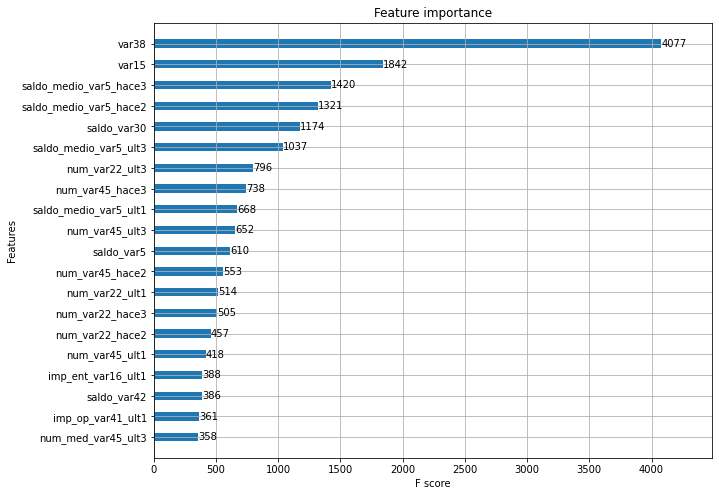

In [60]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

=> XGBoost의 예측 성능을 좌우하는 가장 중요한 피처는 var38,var15 순.

### LightGBM 모델 학습과 하이퍼 파라미터 튜닝

* LightGBM으로 학습 수행하고, ROC-AUC 측정

In [61]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals, verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.817384	valid_0's binary_logloss: 0.165046
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.81863	valid_0's binary_logloss: 0.16
[3]	valid_0's auc: 0.827411	valid_0's binary_logloss: 0.156287
[4]	valid_0's auc: 0.832175	valid_0's binary_logloss: 0.153416
[5]	valid_0's auc: 0.83481	valid_0's binary_logloss: 0.151206
[6]	valid_0's auc: 0.834721	valid_0's binary_logloss: 0.149303
[7]	valid_0's auc: 0.83659	valid_0's binary_logloss: 0.147804
[8]	valid_0's auc: 0.837602	valid_0's binary_logloss: 0.146466
[9]	valid_0's auc: 0.838114	valid_0's binary_logloss: 0.145476
[10]	valid_0's auc: 0.838472	valid_0's binary_logloss: 0.144681
[11]	valid_0's auc: 0.83808	valid_0's binary_logloss: 0.143978
[12]	valid_0's auc: 0.837771	valid_0's binary_logloss: 0.14341
[13]	valid_0's auc: 0.838063	valid_0's binary_logloss: 0.142835
[14]	valid_0's auc: 0.838485	valid_0's binary_logloss: 0.142296
[15]	valid_0's auc: 0.838542	valid_0's binary_logloss: 0.14

=> LightGBM 수행 결과 ROC AUC가 약 0.8396 (XGBoost보다 학습 걸리는 시간 좀 더 단축)

* GridSearchCV로 좀 더 다양한 하이퍼 파라미터에 대한 튜닝 수행 - num_leaves, max_depth, min_child_samples, subsample

In [62]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 200으로 감소
lgbm_clf = LGBMClassifier(n_estimators=200)

params = {'num_leaves':[32,64],'max_depth':[128,160],'min_child_samples':[60,100],'subsample':[0.8,1]}

# cv는 3으로 지정
gridcv = GridSearchCV(lgbm_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc", eval_set=[(X_train, y_train),(X_test, y_test)])

print('GridSearchCV 최적 파라미터:',gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164992
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821835	valid_1's binary_logloss: 0.159874
[3]	valid_0's auc: 0.832192	valid_0's binary_logloss: 0.147167	valid_1's auc: 0.827305	valid_1's binary_logloss: 0.156391
[4]	valid_0's auc: 0.837507	valid_0's binary_logloss: 0.144132	valid_1's auc: 0.8334	valid_1's binary_logloss: 0.15332
[5]	valid_0's auc: 0.842275	valid_0's binary_logloss: 0.141652	valid_1's auc: 0.836036	valid_1's binary_logloss: 0.150954
[6]	valid_0's auc: 0.844971	valid_0's binary_logloss: 0.139662	valid_1's auc: 0.838026	valid_1's binary_logloss: 0.149041
[7]	valid_0's auc: 0.846612	valid_0's binary_logloss: 0.138002	valid_1's auc: 0.837776	valid_1's binary_logloss: 0.147504
[8]	valid_0's auc: 0.848539	valid_0's binary_logloss: 0.136579	valid_1's auc: 0.839506	v

* 해당 하이퍼 파라미터를 LightGBM에 적용하고 다시 학습해 ROC-AUC 측정 결과 도출

In [63]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=32, subsample=0.8, min_child_samples=100, max_depth=128)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals, verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.819488	valid_0's binary_logloss: 0.165016
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.822387	valid_0's binary_logloss: 0.159711
[3]	valid_0's auc: 0.829542	valid_0's binary_logloss: 0.156068
[4]	valid_0's auc: 0.834917	valid_0's binary_logloss: 0.153141
[5]	valid_0's auc: 0.837871	valid_0's binary_logloss: 0.150804
[6]	valid_0's auc: 0.839548	valid_0's binary_logloss: 0.148876
[7]	valid_0's auc: 0.841812	valid_0's binary_logloss: 0.147225
[8]	valid_0's auc: 0.842382	valid_0's binary_logloss: 0.14594
[9]	valid_0's auc: 0.842811	valid_0's binary_logloss: 0.144866
[10]	valid_0's auc: 0.843186	valid_0's binary_logloss: 0.143872
[11]	valid_0's auc: 0.843465	valid_0's binary_logloss: 0.14305
[12]	valid_0's auc: 0.843222	valid_0's binary_logloss: 0.142376
[13]	valid_0's auc: 0.843564	valid_0's binary_logloss: 0.141783
[14]	valid_0's auc: 0.843389	valid_0's binary_logloss: 0.141419
[15]	valid_0's auc: 0.84365	valid_0's binary_logloss

=> LightGBM의 경우 테스트 데이터 세트에서 ROC-AUC가 약 0.8442로 측정

## 09. 분류 실습 - 캐글 신용카드 사기 검출



---

신용카드 데이터 세트 이용해 신용카드 사기 검출 분류 실습

* 레이블인 Class 속성은 매우 불균형한 분포
   + Class는 0과 1로 분류되는데 0이 사기가 아닌 정상적인 신용카드 트랜잭션 데이터, 1은 신용카드 사기 트랜잭션
   + 전체 데이터의 약 0.172%만이 레이블 값이 1, 즉 사기 트랜잭션
   + 일반적으로 사기 검출이나 이상 검출과 같은 데이터 세트는 이처럼 레이블 값이 극도로 불균형한 분포 가지기 쉬워

### 언더 샘플링과 오버 샘플링의 이해

레이블이 불균형한 분포를 가진 데이터 세트(이상 레이블 가질 때) 학습 시 예측 성능 문제 발생 => 적절한 학습 데이터 확보하는 방안 필요 

=> **오버 샘플링**과 **언더 샘플링**

* 언더 샘플링 : 많은 데이터 세트를 적은 데이터 세트 수준으로 감소시키는 방식
   + 과도하게 정상 레이블로 학습/에측하는 부작용 개선 but 정상 레이블의 경우 오히려 제대로 된 학습 수행할 수 없다는 단점
   + 잘 적용하지 않는 방법
* 오버 샘플링 : 이상 데이터와 같이 적은 데이터 세트를 증식하여 학습을 위한 충분한 데이터를 확보하는 방법
   + 원본 데이터의 피처 값들을 아주 약간만 변경하여 증식
   + 대표적 : SMOTE 방법 
      - 적은 데이터 세트에 있는 개별 데이터들의 K 최근접 이웃을 찾아서 이 데이터와 K개 이웃들의 차이를 일정 값으로 만들어서 기존 데이터와 약간 차이가 나는 새로운 데이터들을 생성하는 방식
      - imbalanced-learn (파이썬 패키지)
      

### 데이터 일차 가공 및 모델 학습/예측/평가



* 데이터 세트 로딩

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('/content/drive/MyDrive/data/creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


=> Time 피처의 경우 큰 의미 없어 제거. Amount 피처는 신용카드 트랙잭션 금액. Class는 레이블로서 0의 경우 정상,1의 경우 사기 트랜잭션.

In [65]:
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

=> 결측치 값은 없으며, Class 레이블만 int형이고 나머지 피처들은 모두 float형

* 다양한 데이터 사전 가공, 예측 성능 비교 - get_preprocessed_df()함수와 get_train_test_df() 함수 생성

In [66]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  df_copy.drop('Time',axis=1, inplace=True)
  return df_copy

In [67]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df=None):
  # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
  df_copy = get_preprocessed_df(df)
  # DataFrame의 맨 마지막 칼럼이 레이블, 나머지는 피처들
  X_features = df_copy.iloc[:,:-1]
  y_target = df_copy.iloc[:,-1]
  # train_test_split()으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
  X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
  # 학습과 테스트 데이터 세트 반환
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

* 생성한 학습 데이터 세트와 테스트 데이터 세트의 레이블 값 비율을 백분율로 환산해 서로 비슷하게 분할됐는지 확인

In [68]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0]*100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0]*100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


=> 학습 데이터 레이블의 경우 1값이 약 0.172%, 테스트 데이터 레이블의 경우 1값이 약 0.173%로 잘 분할됨

* 로지스틱 회귀와 LightGBM 기반의 모델이 데이터 가공을 수행하면서 예측 성능이 어떻게 변하는지 확인

In [69]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  # ROC-AUC 추가
  roc_auc = roc_auc_score(y_test, pred_proba)
  print('오차 행렬')
  print(confusion)
  # ROC-AUC print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
  F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [70]:
# 로지스틱 회귀
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]

# 3장에서 사용한 get_clf_eval() 함수를 이용해 평가 수행.
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85281    14]
 [   56    92]]
정확도: 0.9992, 정밀도: 0.8679, 재현율: 0.6216,  F1: 0.7244, AUC:0.9609


=> 테스트 데이터 세트로 측정 시 재현율이 0.6216, ROC-AUC가 0.9609

* 반복적으로 모델 변경해 학습/예측/평가할 것이므로 별도의 함수 생성

In [71]:
# 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행.
def get_model_train_eval(model,ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
  model.fit(ftr_train, tgt_train)
  pred = model.predict(ftr_test)
  pred_proba = model.predict_proba(ftr_test)[:,1]
  get_clf_eval(tgt_test, pred, pred_proba)

* 극도로 불균형한 레이블 값 분포도 -> LGBMClassifier 객체 생성 시 **boost_from_average=False**로 파라미터 설정해야 해

In [72]:
# LightGBM
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85289     6]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9492, 재현율: 0.7568,  F1: 0.8421, AUC:0.9797


=> 재현율 0.7569, ROC-AUC 0.9797. 앞의 로지스틱 회귀보다는 높은 수치

### 데이터 분포도 변환 후 모델 학습/예측/평가

creditcard.csv의 중요 피처 값의 분포도 살펴보기 -> Amount 피처 : 신용 카드 사용 금액. 정상/사기 트랜젹션 결정하는 중요 속성

* Amount 피처의 분포도 확인

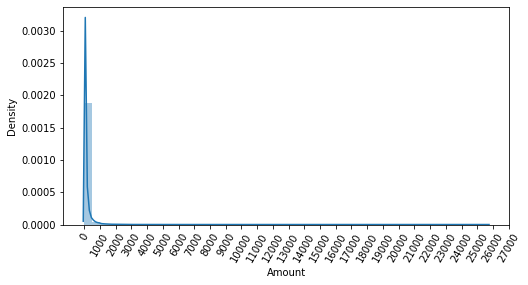

In [73]:
import seaborn as sns
plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000), rotation=60)
sns.distplot(card_df['Amount'])

=> Amount, 즉 카드 사용금액이 1000불 이하인 데이터가 대부분. 많은 금액을 사용한 경우가 발생 -> 꼬리가 긴 형태의 분포 곡선

* 사이킷런의 **StandardScaler** 클래스를 이용해 Amount 피처를 정규 분포 형태로 변환

In [83]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용해 정규 분포 형태로 Amount 피처값 변환하는 로직으로 수정.
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  scaler = StandardScaler()
  amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
  # 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame 맨 앞 칼럼으로 입력
  df_copy.insert(0,'Amount_Scaled',amount_n)
  # 기존 Time, Amount 피처 삭제
  df_copy.drop(['Time','Amount'], axis=1, inplace=True)
  return df_copy

* 학습/테스트 데이터 세트 생성 -> 로지스틱 회귀와 LightGBM 모델 각각 학습/예측/평가

In [84]:
# Amount를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,  F1: 0.7143, AUC:0.9702
### LightGBM 예측 성능 ###
오차 행렬
[[85263    32]
 [  107    41]]
정확도: 0.9984, 정밀도: 0.5616, 재현율: 0.2770,  F1: 0.3710, AUC:0.6383


=> 정규 분포 형태로 Amount 피처값 변환 후 테스트 데이터 세트에 적용한 로지스틱 회귀 및 LightGBM 모델 모두 변환 이전과 비교해 성능 크게 개선 x

* **로그 변환** - 데이터 분포도가 심하게 왜곡되어 있을 경우 적용
   + 원래 값을 log 값으로 변환해 데이터 분포도의 왜곡을 상당 수준 개선
   + 넘파이의 log1p() 함수 이용

In [76]:
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  # 넘파이의 log1p()를 이용해 Amount를 로그 변환
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0,'Amount_Scaled', amount_n)
  df_copy.drop(['Time','Amount'], axis=1, inplace=True)
  return df_copy

* 학습/테스트 데이터 세트 생성 -> 로지스틱 회귀와 LightGBM 모델 각각 학습/예측/평가

In [77]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,  F1: 0.7149, AUC:0.9727
### LightGBM 예측 성능 ###
오차 행렬
[[85266    29]
 [   65    83]]
정확도: 0.9989, 정밀도: 0.7411, 재현율: 0.5608,  F1: 0.6385, AUC:0.7801


=> 두 모델 모두 정밀도, 재현율, ROC-AUC에서 약간씩 성능 개선되었음

### 이상치 데이터 제거 후 모델 학습/예측/평가

이상치 데이터(Outlier/아웃라이어) : 전체 데이터의 패턴에서 벗어난 이상 값을 가진 데이터 -> 머신러닝 모델의 성능에 영향

* 이상치 찾는 방법 - **IQR** 방식 적용
IQR : 사분위(Quantile) 갑의 편차를 이용하는 방법. 박스 플롯 방식으로 시각화
* 사분위 : 전체 데이터를 값이 높은 순으로 정렬한 후 1/4(25%)씩으로 구간 분할

-> IQR : 25% 구간인 Q1 ~ 75% 구간인 Q3의 범위

* IQR 이용해 이상치 데이터 검출하는 방식 : 보통 IQR에 1.5를 곱해 생성된 범위를 이용해 구한 최댓값을 초과하거나 최솟값에 미달하는 데이터를 이상치로 간주하는 것
   + 최댓값 = 3/4 분위수(Q3)에 IQR*1.5 더한 값
   + 최솟값 = 1/4 분위수(Q1)에 IQR*1.5 뺀 값
   + 보통은 1.5 적용

* 어떤 피처의 이상치 데이터 검출? -> 많은 피처가 있을 경우 결정값(레이블)과 가장 상관성이 높은 피처들 위주로 이상치 검출하는 것 좋아

* 각 피처별로 상관도(corr() 이용) 구한 뒤 시본의 **heatmap** 통해 시각화
   + cmap='RdBu' : 양의 상관관계 높을수록 색깔이 진한 파란색. 음의 상관관계가 높을수록 색깔이 진한 빨간색에 가깝게 표현

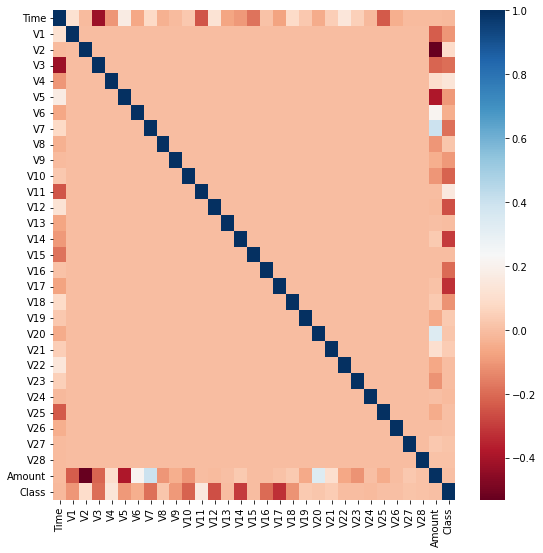

In [78]:
import seaborn as sns

plt.figure(figsize=(9,9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

=> 결정 레이블인 Class 피처와 음의 상관관계가 가장 높은 피처는 V14와 V17

* IQR 이용해 이상치 검출하는 함수 get_outlier() 생성
   + 인자로 DataFrame과 이상치를 검출할 칼럼 입력받아
   + 넘파이의 percentile()로 1/4 분위와 3/4 분위 구해 IQR 계산 -> IQR에 1.5 곱해 구한 최댓값보다 크거나 최솟값보다 작은 값을 이상치로 설정
   + 해당 이상치가 있는 DataFrame Index 반환

In [79]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
  # fraud에 해당하는 column 데이터만 추출, 1/4분위와 3/4분위 지점을 np.percentile로 구함.
  fraud = df[df['Class']==1][column]
  quantile_25 = np.percentile(fraud.values, 25)
  quantile_75 = np.percentile(fraud.values, 75)
  # IQR을 구하고, IQR에 1.5를 곱해 최댓값과 최솟값 지점 구함.
  iqr = quantile_75-quantile_25
  iqr_weight = iqr*weight
  lowest_val = quantile_25-iqr_weight
  highest_val = quantile_75+iqr_weight
  # 최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고 DataFrame index 반환
  outlier_index = fraud[(fraud<lowest_val) | (fraud>highest_val)].index
  return outlier_index

* V14 칼럼에서 이상치 데이터 찾기

In [80]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:',outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


=> 총 4개의 데이터인 8296,8615,9035,9252번 Index가 이상치로 추출

* 이상치 추출하고 삭제하는 로직을 get_processed_df() 함수에 추가해 데이터 가공한 뒤 로지스틱 회귀와 LightGBM 모델 다시 적용

In [81]:
# get_preprocessed_df()를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경.
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0,'Amount_Scaled',amount_n)
  df_copy.drop(['Time','Amount'],axis=1,inplace=True)
  # 이상치 데이터 삭제하는 로직 추가
  outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
  df_copy.drop(outlier_index, axis=0, inplace=True)
  return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712,  F1: 0.7597, AUC:0.9743
### LightGBM 예측 성능 ###
오차 행렬
[[85233    62]
 [  110    36]]
정확도: 0.9980, 정밀도: 0.3673, 재현율: 0.2466,  F1: 0.2951, AUC:0.6229


=> 이상치 데이터 제거한 뒤, 로지스틱 회귀와 LightGBM 모두 예측 성능 크게 향상 

### SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

SMOTE : imbalanced-learn 패키지의 SMOTE 클래스 이용

* 반드시 학습 데이터 세트만 오버 샘플링해야해. 검증/테스트 데이터 세트로 오버 샘플링 x

* 학습 피처/레이블 데이터를 SMOTE 객체의 **fit_resample()** 메서드 이용해 오버 샘플링 적용

In [86]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ',X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ',X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199364, 29) (199364,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 0    199020
1    199020
Name: Class, dtype: int64


=> SMOTE 적용 전 학습 데이터 세트는 199362건, 증식 후 2배 가까이 증식. SMOTE 적용 후 레이블 값이 0과 1의 분포 동일하게 생성

* 학습 데이터 세트 기반으로 먼저 로지스틱 회귀 모델 학습한 뒤 성능 평가

In [87]:
lr_clf = LogisticRegression()
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[83316  1979]
 [   15   133]]
정확도: 0.9767, 정밀도: 0.0630, 재현율: 0.8986,  F1: 0.1177, AUC:0.9796


=> 재현율은 크게 증가. 반대로 정밀도는 급격하게 저하.

(로지스틱 회귀 모델이 오버 샘플링으로 인해 실제 원본보다 너무나 많은 Class=1 데이터를 학습하면서 예측을 지나치게 Class=1로 적용해 정밀도가 급격히 떨어지게 된 것)

* 분류 결정 임곗값에 따른 정밀도와 재현율 곡선을 통해 SMOTE로 학습된 로지스틱 회귀 모델에 어떠한 문제가 발생하고 있는지 시각화

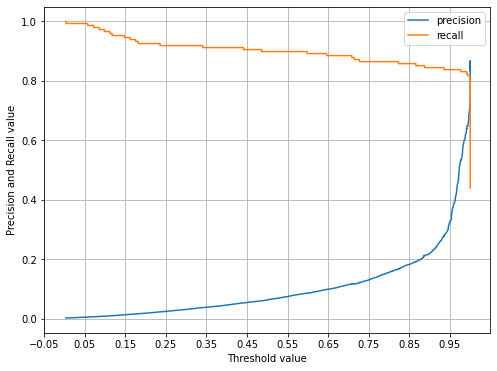

In [88]:
# 3장에서 사용한 precision_recall_curve_plot() 함수 이용
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
from sklearn.metrics import precision_recall_curve

def precision_recall_curve_plot(y_test, pred_proba_c1):
  # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출.
  precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

  # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
  plt.figure(figsize=(8,6))
  threshold_boundary = thresholds.shape[0]
  plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='-', label='precision')
  plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')

  # threshold 값 X축의 Scale을 0.1 단위로 변경
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start,end,0.1),2))

  # x축, y축 label과 legend, 그리고 grid 설정
  plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
  plt.legend(); plt.grid()
  plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

=> 임계값이 0.99 이하에서는 재현율이 매우 좋고 정밀도가 극단적으로 낮으나 0.99 이상에서는 반대로 재현율 대폭 떨어지고 정밀도 높아져.(분류 결정 임계값의 민감도 심해)

* LightGBM 모델을 SMOTE로 오버 샘플링된 데이터 세트로 학습/예측/평가

In [89]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[85280    15]
 [   35   113]]
정확도: 0.9994, 정밀도: 0.8828, 재현율: 0.7635,  F1: 0.8188, AUC:0.9650


=> SMOTE 적용하면 재현율은 높아지나, 정밀도는 낮아지는 것이 일반적.

=> 좋은 SMOTE 패키지일수록 재현율 증가율은 높이고 정밀도 감소율은 낮출 수 있도록 효과적으로 데이터 증식 